##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Use Gemini thinking

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking_REST.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

---
> **Gemini 3 models**: If you are only interested in the new [Gemini 3](https://ai.google.dev/gemini-api/docs/models#gemini-3-pro) new thinking levels, jump directly to the [dedicated section](#gemini3) at the end of this notebook that also includes a [migration guide](#gemini3migration).

---


All Gemini models from the 2.5 generation and the new [Gemini 3 generation](https://ai.google.dev/gemini-api/docs/models#gemini-3-pro) are trained to do a [thinking process](https://ai.google.dev/gemini-api/docs/thinking-mode) (or reasoning) before getting to a final answer. As a result, those models are capable of stronger reasoning capabilities in its responses than previous models.

You'll see examples of those reasoning capabilities with [code understanding](#code_execution), [geometry](#geometry) and [math](#math) problems.

As you will see, the model is exposing its thoughts so you can have a look at its reasoning and how it did reach its conclusions.

## Understanding the thinking models

Thinking models are optimized for complex tasks that need multiple rounds of strategyzing and iteratively solving.

When making REST API calls, you control the thinking behavior by including a thinkingConfig object within the generationConfig in your JSON request payload.

[Gemini 2.5 Flash](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-flash-preview-04-17) in particular, brings the flexibility of using `thinkingBudget` - a parameter
that offers fine-grained control over the maximum number of tokens a model can generate while thinking. Alternatively, you can designate a precise token allowance for the
"thinking" stage through the adjusment of the `thinkingBudget` parameter. This allowance can vary between 0 and 24576 tokens for 2.5 Flash.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

On this notebook most examples are using the `thinkingBudget` parameter since it's compatible with both the 2.5 and the 3 generations of models. For more information about using the `thinkingBudget` with the Gemini thinking model, check the [documentation](https://ai.google.dev/gemini-api/docs/thinking).

**NEW: thinking levels:** [Gemini 3 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-3-pro) introduced a new, easier way to manage the thinking buget by setting a `thinkingLevel` that is documented in the [section of this guide dedicated to Gemini 3](#gemini3).

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [ ]:
import json
import requests

MODEL_ID = "gemini-3-flash-preview" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-2.5-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}
url = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL_ID}:generateContent?key={GOOGLE_API_KEY}"

# Examples

Here are some quite complex examples of what Gemini **thinking** model can solve.

In each of them you can select different models to see how this new model compares to its predecesors.

In some cases, you'll still get the good answer from the other models, in that case, re-run it a couple of times and you'll see that Gemini 2.5 thinking is more consistent thanks to its thinking step.

## Example #1: Brain Teaser with Thinking

You can start by asking the model to explain a concept and see how it does reasoning before answering.

Starting with the adaptive `thinkingBudget` - which is the default when you don't specify a budget - the model will dynamically adjust the budget based on the complexity of the request.

`includeThoughts` tells the model to include its thoughts in the output.

In [ ]:
prompt = """
    You are playing the 20 question game. You know that what you are looking for
    is a aquatic mammal that doesn't live in the sea, and that's smaller than a
    cat. What could that be and how could you make sure?
"""
# The animal I'm thinking of is a platipus

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt}
            ]
        }
    ],
    "generationConfig": {
          "thinkingConfig": {
              "includeThoughts": True,
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

print("THOUGHTS:")
print(response['candidates'][0]['content']['parts'][0]['text'])
print()
print("OUTPUT:")
print(response['candidates'][0]['content']['parts'][1]['text'])

THOUGHTS:
**Here's how I'm thinking about this:**

Okay, so we've got an aquatic mammal, freshwater, smaller than a cat. My mind immediately starts running through the usual suspects. I'm going through the marine mammals first, ruling them out: whales, dolphins, sea lions... nope, definitely not. Manatees and dugongs, too big. Then, I start on the freshwater side. Otters are a possibility, though some are much bigger. Beavers? Too big. Muskrat and Mink are looking promising, and I'm adding platypus because it's aquatic and I need to be inclusive. Water voles, various shrews, and a quick check on the hippo (nope, obviously).

Now, refining based on size, the really strong candidates emerge: the water shrew and vole are ideal. The platypus, being unique, is a great fit. Mink also look good. Muskrat... borderline but possible. I'll include it to show I thought it through.

Based on the information, I'll go with the Water Shrew, Water Vole, Platypus, and Mink, as distinct options. They cov

In [ ]:
print(response)

{'error': {'code': 400, 'message': 'Invalid JSON payload received. Unknown name "includeThoughts" at \'generation_config\': Cannot find field.', 'status': 'INVALID_ARGUMENT', 'details': [{'@type': 'type.googleapis.com/google.rpc.BadRequest', 'fieldViolations': [{'field': 'generation_config', 'description': 'Invalid JSON payload received. Unknown name "includeThoughts" at \'generation_config\': Cannot find field.'}]}]}}


Inspecting the Response Metadata: After making the REST call, the response JSON contains usageMetadata. This object provides information about the token counts for the request. Look for the `thoughtsTokenCount` field within usageMetadata to see how many tokens were consumed by the thinking process for this request. You'll also see `promptTokenCount`, `candidatesTokenCount` (for the final output), and `totalTokenCount`. As you can see here, the model used a significant number of tokens in the thinking steps.

In [ ]:
print("Prompt tokens:",response["usageMetadata"]["promptTokenCount"])
print("Thoughts tokens:",response["usageMetadata"]["thoughtsTokenCount"])
print("Output tokens:", response["usageMetadata"]["candidatesTokenCount"])
print("Total tokens:", response["usageMetadata"]["totalTokenCount"])

Prompt tokens: 58
Thoughts tokens: 1477
Output tokens: 820
Total tokens: 2355


### Disabling the thinking steps

You can explicitly disable the thinking steps by including the `thinkingConfig` object in the `generationConfig` and setting the `thinkingBudget` parameter to `0` in the JSON payload. This tells the model not to perform any internal reasoning steps before generating the final output. You'll likely see that in this case, the model doesn't think of the platypus as a possible answer.

Note that you can't disable thinking on pro models.

In [ ]:
if "-pro" not in MODEL_ID:
  prompt = """
      You are playing the 20 question game. You know that what you are looking for
      is a aquatic mammal that doesn't live in the sea, and that's smaller than a
      cat. What could that be and how could you make sure?
  """

  data = {
      "contents": [
          {
              "parts": [
                  {"text": prompt}
              ]
          }
      ],
      "generationConfig": {
            "thinkingConfig": {
                "thinkingBudget": 0,
            }
      }
  }

  response = requests.post(
    url,
    headers={'Content-Type': 'application/json'},
    data=json.dumps(data)
  ).json()

  print(response['candidates'][0]['content']['parts'][0]['text'])

else
  print("You can't disable thinking for pro models.")

This is a fun challenge! Let's break it down.

**The Object:** A aquatic mammal that doesn't live in the sea, and that's smaller than a cat.

**Possible Candidate:** The most likely candidate that fits all those criteria is a **river otter pup**.

**Why a River Otter Pup?**

*   **Aquatic Mammal:** Yes, otters are well-known aquatic mammals.
*   **Doesn't Live in the Sea:** While some otters live in coastal areas, river otters specifically inhabit freshwater environments like rivers, lakes, and marshes.
*   **Smaller than a Cat:** An adult river otter is definitely larger than a cat. However, a newborn or very young **pup** (baby otter) would be significantly smaller than a domestic cat. They are born blind and helpless, and quite tiny.

**How to Make Sure (Your 20 Questions Strategy):**

To confirm this, you'd use your 20 questions to narrow down the possibilities. Here's a possible line of questioning, aiming to eliminate other options and pinpoint the river otter pup:

1.  **Is it a

Now you can see that the response is faster as the model didn't perform any thinking step. Also you can see that no tokens were used for the thinking step:

In [ ]:
print("Prompt tokens:",response["usageMetadata"]["promptTokenCount"])
print("Thoughts tokens:",response["usageMetadata"]["thoughtsTokenCount"] if "thoughtsTokenCount" in response["usageMetadata"] else "None")
print("Output tokens:", response["usageMetadata"]["candidatesTokenCount"])
print("Total tokens:", response["usageMetadata"]["totalTokenCount"])

Prompt tokens: 59
Thoughts tokens: None
Output tokens: 786
Total tokens: 845


## Example #2: Physics problem

Now, try with a simple physics comprehension example. First you can disable the `thinkingBudget` to see how the model performs:

In [ ]:
if "-pro" not in MODEL_ID:
  prompt = """
      A cantilever beam of length L=3m has a rectangular cross-section (width b=0.1m, height h=0.2m) and is made of steel (E=200 GPa).
      It is subjected to a uniformly distributed load w=5 kN/m along its entire length and a point load P=10 kN at its free end.
      Calculate the maximum bending stress (σ_max).
  """

  data = {
      "contents": [
          {
              "parts": [
                  {"text": prompt}
              ]
          }
      ],
      "generationConfig": {
            "thinkingConfig": {
                "thinkingBudget": 0
            }
      }
  }

  response = requests.post(
    url,
    headers={'Content-Type': 'application/json'},
    data=json.dumps(data)
  ).json()

  print(response['candidates'][0]['content']['parts'][0]['text'])

else
  print("You can't disable thinking for pro models.")

Here's how to calculate the maximum bending stress for the cantilever beam:

**1. Define Given Parameters:**

*   Length (L) = 3 m
*   Width (b) = 0.1 m
*   Height (h) = 0.2 m
*   Modulus of Elasticity (E) = 200 GPa = 200 * 10^9 Pa
*   Uniformly distributed load (w) = 5 kN/m = 5000 N/m
*   Point load (P) = 10 kN = 10000 N

**2. Calculate the Moment of Inertia (I) for a Rectangular Cross-Section:**

The formula for the moment of inertia for a rectangular cross-section about the neutral axis is:
I = (b * h^3) / 12

I = (0.1 m * (0.2 m)^3) / 12
I = (0.1 m * 0.008 m^3) / 12
I = 0.0008 m^4 / 12
I = 6.6667 * 10^-5 m^4

**3. Determine the Maximum Bending Moment (M_max):**

For a cantilever beam, the maximum bending moment occurs at the fixed end. We need to consider the contribution from both the uniformly distributed load and the point load.

*   **Bending moment due to uniformly distributed load (M_w):**
    M_w = (w * L^2) / 2
    M_w = (5000 N/m * (3 m)^2) / 2
    M_w = (5000 N/m * 9 m^2)

Metadata (Thinking Disabled): As expected, the `usageMetadata` for this request should show a `thoughtsTokenCount` of `0` or absence, as thinking was explicitly disabled in the request payload.

In [ ]:
print("Prompt tokens:",response["usageMetadata"]["promptTokenCount"])
print("Thoughts tokens:",response["usageMetadata"]["thoughtsTokenCount"] if "thoughtsTokenCount" in response["usageMetadata"] else "None")
print("Output tokens:", response["usageMetadata"]["candidatesTokenCount"])
print("Total tokens:", response["usageMetadata"]["totalTokenCount"])

Prompt tokens: 95
Thoughts tokens: None
Output tokens: 761
Total tokens: 856


Then, set a fixed maximum budget `(e.g., thinkingBudget=4096)` for the thinking step by including the `thinkingConfig` object with `thinkingBudget` set in the JSON payload. See how the model's output changes.

In [ ]:
prompt = """
    A cantilever beam of length L=3m has a rectangular cross-section (width b=0.1m, height h=0.2m) and is made of steel (E=200 GPa).
    It is subjected to a uniformly distributed load w=5 kN/m along its entire length and a point load P=10 kN at its free end.
    Calculate the maximum bending stress (σ_max).
"""

thinkingBudget = 4096 # @param {type:"slider", min:0, max:24576, step:1}

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt}
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "includeThoughts": True,
              "thinkingBudget": thinkingBudget
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

print("THOUGHTS:")
print(response['candidates'][0]['content']['parts'][0]['text'])
print()
print("OUTPUT:")
print(response['candidates'][0]['content']['parts'][1]['text'])

THOUGHTS:
**Solving for Maximum Bending Stress in a Cantilever Beam**

Alright, let's break this down. The goal is clear: find the maximum bending stress in that cantilever beam. The key here, as always, is understanding where the maximum stress will occur.  With a cantilever, it's a no-brainer – it's at the fixed support, where the bending moment is the greatest.

First, I need to have the bending stress formula at my fingertips: $\sigma = \frac{M y}{I}$.  $M$ is the bending moment, $y$ is the distance to the fiber, and $I$ is the moment of inertia. I'll need to calculate those.

Since it's a rectangular cross-section (b = 0.1 m, h = 0.2 m), the moment of inertia is straightforward.  $I = \frac{b h^3}{12}$, giving me $I = \frac{0.1 \times 0.2^3}{12} = \frac{1}{15000} m^4$.  For a rectangle, the distance to the extreme fiber, *c*, is just half the height, or 0.1 m.  I've got my section properties sorted.

Now for the moment. There are two loads: a point load at the free end and a unifo

Metadata (Thinking Enabled): Now, examine the `usageMetadata` for the call where `thinkingBudget` was set to a positive value. You should see a non-zero `thoughtsTokenCount`, indicating the number of tokens used for the thinking process (which will be less than or equal to the `thinkingBudget` you set).

In [ ]:
print("Prompt tokens:",response["usageMetadata"]["promptTokenCount"])
print("Thoughts tokens:",response["usageMetadata"]["thoughtsTokenCount"], '/', thinkingBudget if "thoughtsTokenCount" in response["usageMetadata"] else "None")
print("Output tokens:", response["usageMetadata"]["candidatesTokenCount"])
print("Total tokens:", response["usageMetadata"]["totalTokenCount"])

Prompt tokens: 95
Thoughts tokens: 1674 / 4096
Output tokens: 955
Total tokens: 2724


Keep in mind that the largest the thinking budget is, the longest the model will spend time thinking, with means a longer computation time and a more expensive request.

<a name="geometry"></a>
## Example #3: Geometry problem (with image)

This geometry problem requires complex reasoning and is also using Gemini multimodal abilities to read the image.
In this case, you are fixing a value to the `thinkingBudget` so the model will use up to 8196 tokens for the thinking step.

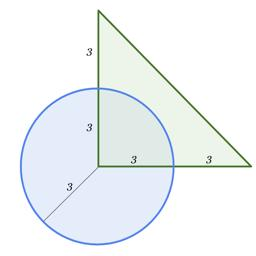

In [ ]:
import base64
from PIL import Image

!wget https://storage.googleapis.com/generativeai-downloads/images/geometry.png -O geometry.png -q

display(Image.open("geometry.png").resize((256,256)))

with open("geometry.png", "rb") as image_file:
     encoded_string = base64.b64encode(image_file.read()).decode("utf-8")

In [ ]:
prompt = "What's the area of the overlapping region?"

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt},
                {
                    "inlineData": {
                        "mimeType": "image/png",
                        "data": encoded_string
                    }
                }
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "includeThoughts": True,
              "thinkingBudget": 8196
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

print("THOUGHTS:")
print(response['candidates'][0]['content']['parts'][0]['text'])
print()
print("OUTPUT:")
print(response['candidates'][0]['content']['parts'][1]['text'])

THOUGHTS:
**Calculating the Overlap: A Quadrant's Area**

Okay, so I'm looking at this image and immediately, the geometry jumps out. It's about finding the area of the intersection between a circle and a right-angled triangle.  My first observation is the circle.  I see three segments labeled '3' extending from the center – bingo, the radius (R) is 3. The circle is divided into quadrants, and the crucial overlap seems to be the top-right one.

The triangle is a right isosceles triangle, also with sides labeled '3'.  That means its legs have a length of 3 and it's a 45-45-90 triangle. Crucially, the right angle's vertex sits *exactly* at the center of the circle, and the triangle's legs are aligned along the x and y axes (assuming the center is at the origin), extending outwards.

This makes the overlapping region crystal clear: it's a perfect quarter-circle, or a quadrant. The quadrant is enclosed by the two radii (both length 3) and the circular arc. Because the legs of the triangle 

<a name="brain"></a>
## Example #4: Brain teaser with a twist

Here's another brain teaser based on an image, this time it looks like a mathematical problem, but it cannot actually be solved mathematically. If you check the toughts of the model you'll see that it will realize it and come up with an out-of-the-box solution.

In this case, you are fixing a value to the `thinkingBudget` so the model will use up to 24576 tokens for the thinking step.

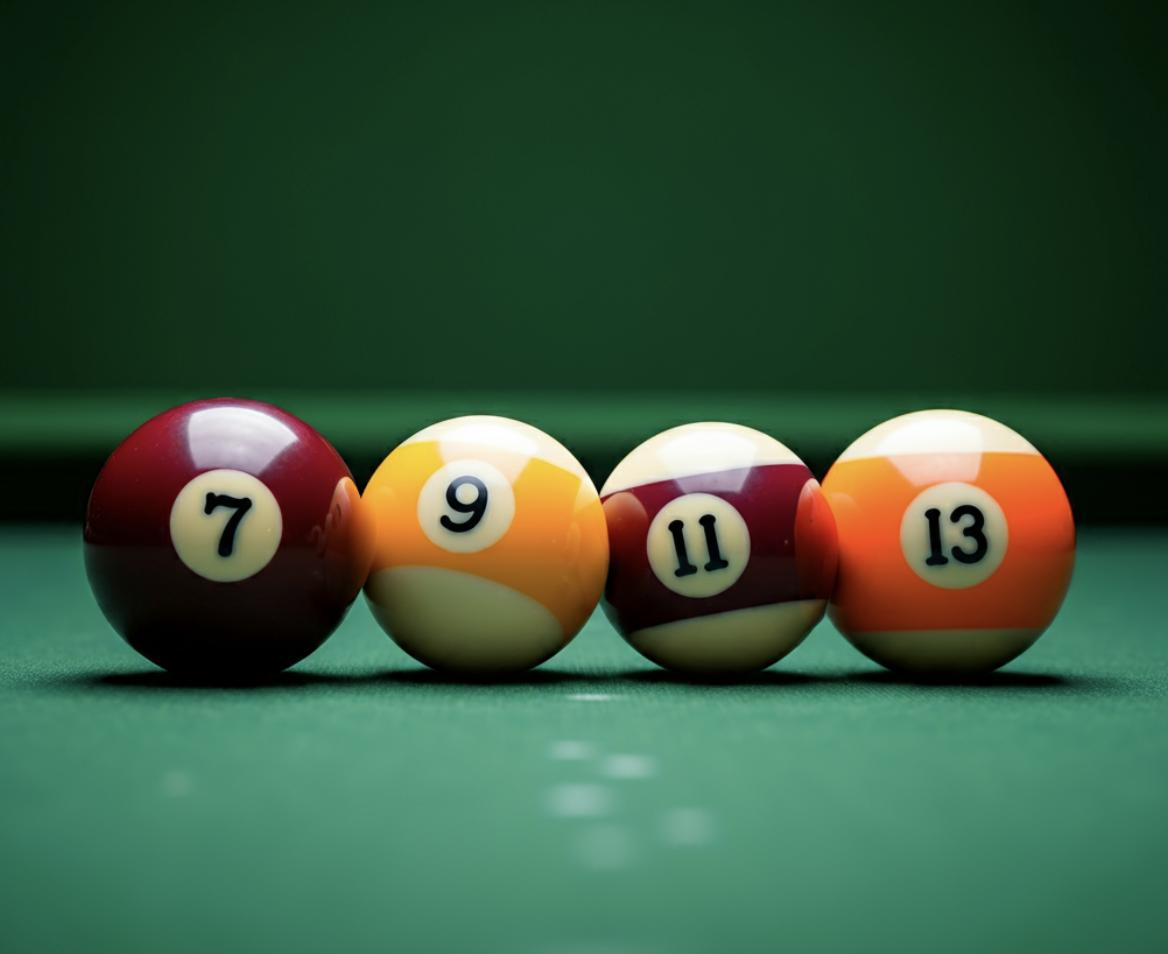

In [ ]:
!wget https://storage.googleapis.com/generativeai-downloads/images/pool.png -O pool.png -q

display(Image.open("pool.png"))

with open("pool.png", "rb") as image_file:
     encoded_string = base64.b64encode(image_file.read()).decode("utf-8")

In [ ]:
prompt = "How do I use and manipulate three of the pool balls to sum up to 30?"

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt},
                {
                    "inlineData": {
                        "mimeType": "image/png",
                        "data": encoded_string
                    }
                }
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "includeThoughts": True,
              "thinkingBudget": 24576
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

print("THOUGHTS:")
print(response['candidates'][0]['content']['parts'][0]['text'])
print()
print("OUTPUT:")
print(response['candidates'][0]['content']['parts'][1]['text'])

THOUGHTS:
**Decoding the Pool Ball Puzzle**

Alright, let's break this down. The user's after a way to get three pool balls to add up to 30. Looking at the options – 7, 9, 11, and 13 – it's immediately obvious that a straightforward sum isn't going to work.  My initial reaction is to just go through combinations, which I do, but of course, none of them equal 30.

This screams "manipulation" – they practically spelled it out! In a pool context, what can be manipulated? Well, you can't really change the numbers on the balls, but perhaps their *orientation*? That's when the "9" immediately jumps out. Flip it over, and you've got a "6".

Let's swap that 9 for a 6 and try again. Now, with the set 7, 6, 11, and 13, I experiment, and *voila* - 6 + 11 + 13 = 30.  There it is!  It has to be the 6-ball (which we've created from the rotated 9), the 11-ball, and the 13-ball.

I briefly double-check to make sure no other number could similarly be manipulated, but 9 is the only viable candidate. The

<a name="math"></a>
## Example #5: Math puzzle

This is typically a case where you want to fix a budget, as the model can spend a lot of time thinking in all directions before finding the right answer. It should not be too low either as non-thinking models have trouble with such questions.

Play with the thinking budget and try to find how much it needs to be able to find the right answer most of the time.

Note that Pro is usually better than Flash for those kind of riddles, but does not have the thinking budget yet.

In [ ]:
prompt = """
   How can you obtain 565 with 10 8 3 7 1 and 5 and the common operations?
   You can only use a number once.
"""

thinkingBudget = 24576 # @param {type:"slider", min:0, max:24576, step:1}

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt},
                {
                    "inlineData": {
                        "mimeType": "image/png",
                        "data": encoded_string
                    }
                }
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "includeThoughts": True,
              "thinkingBudget": 24576
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

print("THOUGHTS:")
print(response['candidates'][0]['content']['parts'][0]['text'])
print()
print("OUTPUT:")
print(response['candidates'][0]['content']['parts'][1]['text'])

THOUGHTS:
**A Dive into Number Manipulation: Finding 565**

Alright, let's break this down. My goal is to craft the number 565 using 10, 8, 3, 7, 1, and 5, each used only once, and sticking to addition, subtraction, multiplication, and division. Since 565 is big, multiplication's the key.

First thought: get close with multiplication.  8*7 gets me to 56, and that's awfully close to 560, which leads me to 8*7*10 = 560. Then, I need to add 5.  This one works!  I can see one solution: (8 * 7 * 10) + 5 = 565, however, the challenge *implies* I need to use all the numbers.

Okay, let's regroup. I have to think harder about using *all* the numbers. Since the target number ends in 5, maybe I can find a way to use 5 as a multiplier or somehow end up at 565 with multiplication by 5.

If I divide 565 by 5, I get 113.  Can I make 113 using the remaining numbers? Let's give it a try.  I can quickly see that 10 * X should be close to 113. That gets me to {10, 8, 3, 7, 1} and the task of making 113.

<a name="gemini3"></a><a name="thinkingLevel"></a>
# Thinking level for Gemini 3

In [ ]:
# @title Run this cell to set everything up (especially if you jumped directly to this section)
import json
import requests
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# Select the Gemini 3 model

GEMINI3_MODEL_ID = "gemini-3-pro-preview" # @param ["gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}
url = f"https://generativelanguage.googleapis.com/v1beta/models/{GEMINI3_MODEL_ID}:generateContent?key={GOOGLE_API_KEY}"

Instead of using a `thinking_budget` like the 2.5 generation, the third generation of Gemini models uses "thinking levels" to make it simpler to manage.

You can set that thinking level to "minimal" (more or less equivalent to "off"), "low", "medium" or "high" (default). This will indicate to the model if it allowed to do a lot of thinking. Since the thinking process stays dynamic, `high` doesn't mean it will always use a lot of token in its thinking phase, just that it's allowed to. Note that Gemini 3 Pro only supports "low" and "high".

`thinking_budget` is still supported by Gemini 3 Pro.

Check the Gemini 3 documentation](https://ai.google.dev/gemini-api/docs/gemini-3) for more details.

In [ ]:
prompt = """
  Find what I'm thinking of:
    It moves, but doesn't walk, run, or swim.
    It has no fixed shape and if cut into pieces, those pieces will keep living and moving.
    It has no brain but can solve complex mazes.
"""

thinkingLevel = "High" # @param ["Minimal", "Low", "Medium", "High"]

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt},
                {
                    "inlineData": {
                        "mimeType": "image/png",
                        "data": encoded_string
                    }
                }
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "includeThoughts": True,
              "thinkingLevel": thinkingLevel
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

print("THOUGHTS:")
print(response['candidates'][0]['content']['parts'][0]['text'])
print()
print("OUTPUT:")
print(response['candidates'][0]['content']['parts'][1]['text'])

THOUGHTS:
**Okay, here's my thought process on this riddle:**

First off, I'm breaking down the task – figure out what the riddle's talking about. The clues are clear: something moves in a non-traditional way, has no set form, and can survive being chopped up. The clincher is the "no brain, maze solver" part - that's *got* to be the famous slime mold, *Physarum polycephalum*. It’s a classic biology fact!

Then, I'm checking the image. It’s got these pool balls with numbers. The numbers are consecutive odds, but what does that have to do with the riddle?  At first glance, it feels like a red herring, or maybe a “follow the pattern” type thing? Maybe the numbers are a cipher? But it’s a distraction. The text's description is too specific.

I start to wonder if the image is a code. "G I K M" doesn't immediately strike me. Is there a connection to the word "pool" or "billiards" somehow? Maybe a double meaning with "slime pool"? It's a stretch. The text strongly suggests **Slime Mold**.

I 

<a name="gemini3migration"></a>
### Migrating from `thinking_budget` to `thinking_level`

With only high and low levels currently available, the migration should be quite simple:
* If you were previously using **complex prompt engineering** (like Chain-of-thought) to force Gemini 2.5 to reason, go with `ThinkingLevel.HIGH`.
* If you were using **dynamic thinking**, also go with `ThinkingLevel.HIGH`.
* On the contrary if you were setting a low `thinking_budget`, select `ThinkingLevel.LOW`.
* If you want to deactivate thinking because **latency** is important, select `ThinkingLevel.MINIMAL`.
* If you are in doubt, keep the default value (`ThinkingLevel.HIGH`), as the dynamic thinking will scale the thinking depending on your use case.


# Next Steps

Try Gemini 2.5 Pro Experimental in
[Google AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.5-pro-exp-03-25), and learn more about [Prompting for thinking models](https://ai.google.dev/gemini-api/docs/prompting-with-thinking).

For more examples of the Gemini capabilities, check the other [Cookbook examples](https://github.com/google-gemini/cookbook). You'll learn how to use the [Live API](./Get_started.ipynb), juggle with [multiple tools](../examples/LiveAPI_plotting_and_mapping.ipynb) or use Gemini [spatial understanding](./Spatial_understanding.ipynb) abilities.